In [1]:
using Pkg
Pkg.activate("")

  Activating project at `~/GitHub/Poplar.jl`


In [2]:
using Cropbox 

In [3]:
Pkg.update()

    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/GitHub/Poplar.jl/Project.toml`
  No Changes to `~/GitHub/Poplar.jl/Manifest.toml`
Precompiling project...
  ✓ Poplar
  1 dependency successfully precompiled in 15 seconds. 227 already precompiled.


In [4]:
using BlackBoxOptim

In [5]:
using Poplar

## Model

The Cropbox poplar model, based on 3PG, is using NPP as the proportion of GPP but, to implement respiration, the defintion is newly defined: NPP = GPP - each organ's respiration

@system MaintenanceRespiration(Poplar.Weather, Poplar.Foliage, Poplar.Root, Poplar.Stem, Controller)begin
        
    Q10: temperature_sensitivity_conefficient => 2.0 ~ preserve(parameter) #dimensionless
    k_root: root_maintenance_coefficient => 0.03 ~ preserve(parameter, u"g/g/d"#=gCO2 25oC=#)

    Root_Rp(k_root, Q10, WR, T_air): root_maintenance_respiration => begin
        k_root * WR * Q10^((T_air-25) / 10)
    end ~ track(u"hr^-1")
       
end 

In [6]:
CUH_Sabrina = @config(
    :Atmosphere => (
        data = Poplar.loadwea(("data/CUHUpdated.csv"), tz"America/Los_Angeles"),
    )
)

Roza_Sabrina = @config(
    :Atmosphere => (
        data = Poplar.loadwea(("data/RozaUpdated.csv"), tz"America/Los_Angeles"),
    )
)

data,=,188086×9 DataFrame…


In [7]:
config_default = @config(
    Poplar.config_Calendar,
    Poplar.config_Atmosphere,
)

init,=,"ZonedDateTime(2014, 4, 5, tz""America/Los_Angeles"")"
last,=,"ZonedDateTime(2021, 12, 31, tz""America/Los_Angeles"")"
data,=,70128×9 DataFrame…


In [8]:
config_CUH_Sabrina = @config(
    Poplar.Root => (
        k_root_20 =  24 * 1000, #ng/kg/s
    ),
    Poplar.Stem => (
        k_stem_20 = 24 * 1000, #ng/kg/s
    ),
    Poplar.Foliage => (
        k_leaf_20 = 105.3 * 1000, #ng/kg/s
    ),
    Poplar.config_Calendar,
    CUH_Sabrina,

    Poplar.Sun => (
        lat = 47.66,
        long = -122.29,
        alt = 10.88, #Seattle
    ),

    Poplar.WaterBalance => (
        irrigation = 0,
    ),

)

k_root_20,=,24000 ng kg⁻¹ s⁻¹
k_stem_20,=,24000 ng kg⁻¹ s⁻¹
k_leaf_20,=,105300.0 ng kg⁻¹ s⁻¹
init,=,"ZonedDateTime(2014, 4, 5, tz""America/Los_Angeles"")"
last,=,"ZonedDateTime(2021, 12, 31, tz""America/Los_Angeles"")"
data,=,93686×9 DataFrame…
lat,=,47.66°
long,=,-122.29°
alt,=,10.88 m
irrigation,=,0 mm hr⁻¹


In [9]:
config_Roza_Sabrina = @config(
    Poplar.Root => (
        k_root_20 =  24 * 1000, #ng/kg/s
    ),
    Poplar.Stem => (
        k_stem_20 = 24 * 1000, #ng/kg/s
        Q10_stem_below30C = 2.0,
        Q10_stem_above30C = 1.61,
    ),
    Poplar.Foliage => (
        k_leaf_20 = 105.3 * 1000, #ng/kg/s
    ),
    Poplar.config_Calendar,
    Roza_Sabrina,

    Poplar.Sun => (
        lat = 46.29,
        long = -119.73,
        alt = 365.58,
    ),

    Poplar.WaterBalance => (
        irrigation = 0.05,
    ),
)

k_root_20,=,24000 ng kg⁻¹ s⁻¹
k_stem_20,=,24000 ng kg⁻¹ s⁻¹
Q10_stem_below30C,=,2.0
Q10_stem_above30C,=,1.61
k_leaf_20,=,105300.0 ng kg⁻¹ s⁻¹
init,=,"ZonedDateTime(2014, 4, 5, tz""America/Los_Angeles"")"
last,=,"ZonedDateTime(2021, 12, 31, tz""America/Los_Angeles"")"
data,=,188086×9 DataFrame…
lat,=,46.29°
long,=,-119.73°
alt,=,365.58 m


In [10]:
New_Roza = simulate(Poplar.Model;
    config = @config(
        config_Roza_Sabrina,
        Poplar.config_GasExchange_Newone
    ),
    stop = 5u"yr",
    snap = 6u"hr"
);

Progress: 100%[===========================] Time: 0:00:21 ( 0.49 ms/it)


In [11]:
New_CUH = simulate(Poplar.Model;
    config = @config(
        config_CUH_Sabrina,
        Poplar.config_GasExchange_Newone
    ),
    stop = 5u"yr",
    snap = 6u"hr"
);

Progress: 100%[===========================] Time: 0:00:21 ( 0.48 ms/it)


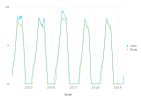

In [12]:
p = Cropbox.plot(New_CUH, :time, :LAI;
    #title="Canopy Biomass (Tree)",
    names=["CUH"],
    #xlab="Year",
    #ylab="Biomass (t/ha)",
    kind=:line,
)

Cropbox.plot!(p, New_Roza, :time, :LAI;
    names=["Roza"],
    kind=:line
)

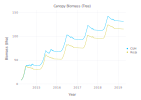

In [13]:
p = Cropbox.plot(New_CUH, :time, :W_ton;
    title="Canopy Biomass (Tree)",
    names=["CUH"],
    xlab="Year",
    ylab="Biomass (t/ha)",
    ylim=[0, 150],

    kind=:line,
)

Cropbox.plot!(p, New_Roza, :time, :W_ton;
    names=["Roza"],
    kind=:line
)

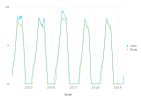

In [14]:
p = Cropbox.plot(New_CUH, :time, :LAI;
    #title="Canopy Biomass (Tree)",
    names=["CUH"],
    #xlab="Year",
    #ylab="Biomass (t/ha)",
    #ylim=[0, 150],

    kind=:line,
)

Cropbox.plot!(p, New_Roza, :time, :LAI;
    names=["Roza"],
    kind=:line
)